# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?



**Ответ:**$$ w_{new} = w_{old} - \frac{\alpha}{n}\sum_{i=1}^{n}\left(y_{i} - x_{i}\cdot w_{old}\right) x_{i} - \frac{\alpha}{C} w_{old} $$

Интуитивно градиент - это направление наискорейшего роста, соответственно когда мы идем в сторону антиградиента, мы наискорейшим образом меняем аргумент функционала качества так, чтобы минимизировать его.

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

**Ответ:**$$ w_{new} = w_{old} + \frac{\alpha}{n} \sum_{i=1}^{n} \big(y_{i} - \sigma(x_{i} \cdot w_{old}) \big) x_{i} - \frac{\alpha}{C} w_{old} $$

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

**Ответ:** 

(1) Из лекции известно, что

$$ \nabla_w Q(w) = \frac{2}{N}(X^T X w - X^T y). $$

Нужно взять еще раз производную (получится Гессиан) и показать, что он положительно определен

$$ \nabla_w \left( \frac{2}{N}(X^T X w - X^T y) \right) = \frac{2}{N} X^T X. $$

Осталось показать, что $ \forall $ вектора $ v \neq 0 $ верно $ v^T X^T X v > 0. $ Это эквивалентно $ (Xv)^T Xv > 0. $

А это есть скалярное произведение вектора $ Xv $ на себя же, то есть $ (Xv,\ Xv). $

По свойству скалярного произведения $ (Xv,\ Xv) \geq 0 $ и $ (Xv,\ Xv) = 0 \Leftrightarrow Xv = 0. $

Но так как матрица $ X $ имеет строчек не больше чем столбцов и имеет полный ранг, то $ Xv \neq 0,\ v \neq 0. $

Значит, $ (Xv,\ Xv) > 0 $. Это доказывает, что найденное решение является точкой минимума.

(2) С добавлением регуляризации функционал качества примет вид

$$ Q(w) = \frac{2}{N} (Xw - y)^T (Xw - y) + \frac{1}{C} w^T w. $$

Возьмем градиент

$$ \nabla_w Q(w) = \frac{2}{N}(X^T X w - X^T y) + \frac{2}{C} w. $$

Решая уравнение $ \nabla_w Q(w) = 0 $, получим

$$ \frac{1}{N}(X^T X w - X^T y) + \frac{1}{C} w = 0, $$

$$ \left( \frac{1}{N} X^T X + \frac{1}{C} I \right) w = X^T y, $$ где $ I $ - единичная матрица.

Тогда 
$$ w = \left( \frac{1}{N} X^T X + \frac{1}{C} I \right)^{-1} X^T y. $$

Если матрица $ X $ имеет линейно зависимые признаки, то матрица $ X^T X $ может быть плохо обусловленной (то есть плохо обратимой) и $ rank(X) = rank(X^T X). $ Тогда при добавлении регуляризации приходится обращать не $ X^T X $, а $ \frac{1}{N} X^T X + \frac{1}{C} I $. То есть регуляризация помогает обратить матрицу.

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

Итак, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

**Ответ:**

Чтобы минимизировать мат. ожидание, приравняем нулю ее производную

$$ E'(L|x_i) = -p(y_i = 1 | x_i)(1 - a(x_i)) x_i + p(y_i = 0) a(x_i) x_i = 0. $$

Тогда

$$ -p(y_i = 1 | x_i) + a(x_i)(p(y_i = 1 | x_i) + p(y_i = 0 | x_i)) = 0, $$

$$ a(x_i) = p(y_i = 1 | x_i). $$

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

**Ответ:** не нужно, так как мы вводим свободный член для учета общего сдвига, то есть для ситуаций, когда при равенстве нулю всех признаков, целевая функция не равна нулю. **А это число не должно зависеть от степени влияния каждого отдельного признака**, то есть от величины абсолютного значения других весов. Добавив же его в регулиризацию, мы установим такую зависимость, что приведет к уменьшению его абсолютного значения.

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
#     переводим в формат numpy на случай, если данные поданы в формате list
    X = np.asarray(X)
    y = np.asarray(y)
    
#     перемешиваем данные, если это требуется
    perm = np.arange(len(X))
    
    if shuffle == True:
        perm = np.random.permutation(len(X))
        
    X = X[perm]
    y = y[perm]
    
#     считаем число батчей
    num_of_batches = len(X) // batch_size
    
    if len(X) % batch_size != 0:
        num_of_batches += 1
        
#     возвращаем значения
    for i in range(num_of_batches):
        X_batch = X[i * batch_size:(i+1) * batch_size]
        y_batch = y[i * batch_size:(i+1) * batch_size]
        yield (X_batch, y_batch)

In [7]:
#%%pycodestyle

def sigmoid(X):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    sigm_value_x = 1/(1 + np.exp(-X))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, batch_size=1, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """

        if self.model_type == 'lin_reg':
            loss = ((self.predict(X_batch) - y_batch)**2).sum() / X_batch.shape[0]
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C
                    
        else:
            pred = self.predict(X_batch)
            loss = - (y_batch*np.log2(pred) + (1-y_batch)*np.log2(1-pred)).sum()
            loss /= X_batch.shape[0]
            loss += np.dot(self.weights[1:], self.weights[1:]) / self.C                    
        
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        if self.model_type == 'lin_reg':
            loss_grad = 2*((self.predict(X_batch) - y_batch).reshape(-1,1)*X_batch).sum(axis=0)
            loss_grad /= X_batch.shape[0]
            loss_grad += 2*np.concatenate(([0], self.weights[1:])) / self.C
                         
        else:
            pred = self.predict(X_batch)
            loss_grad = - ((y_batch - pred).reshape(-1,1)*X_batch).sum(axis=0)
            loss_grad /= np.log(2)*X_batch.shape[0]
            loss_grad += 2*np.concatenate(([0], self.weights[1:])) / self.C
        
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        
        self.weights = self.weights - self.alpha*new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        
        X = np.c_[np.ones(X.shape[0]), X]
        np.random.seed(55)
        self.weights = np.random.normal(0,1,size=X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)
        else:
            y_hat = sigmoid(np.dot(X, self.weights))
        
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [8]:
def plot_decision_boundary(X, y):
    clf_lin = MySGDClassifier(batch_generator, C=2, alpha=0.01, 
                              batch_size=100, max_epoch=100, model_type='lin_reg')
    clf_lin.fit(X, y)

    clf_log = MySGDClassifier(batch_generator, C=2, alpha=0.01, 
                              batch_size=100, max_epoch=100, model_type='log_reg')
    clf_log.fit(X, y)

    def foo_lin(args):
        return - (clf_lin.weights[0] - 0.5 + args*clf_lin.weights[1]) / clf_lin.weights[2]

    def foo_log(args):
        return - (clf_log.weights[0] + args*clf_log.weights[1]) / clf_log.weights[2]

    args_lin = np.linspace(0, 6, 100)
    args_log = np.linspace(1, 5, 100)

    res_lin = foo_lin(args_lin)
    plt.plot(args_lin, res_lin, label='lin regression')

    res_log = foo_log(args_log)
    plt.plot(args_log, res_log, label='log regression')

    plt.legend()

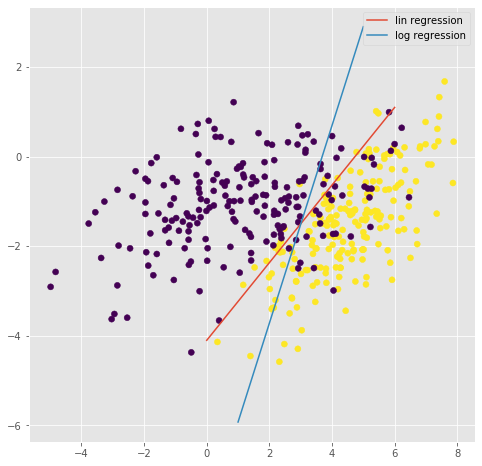

In [9]:
np.random.seed(0)

fig = plt.figure(figsize=(8,8))

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plot_decision_boundary(X, y)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [10]:
from sklearn.datasets import make_classification

In [11]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

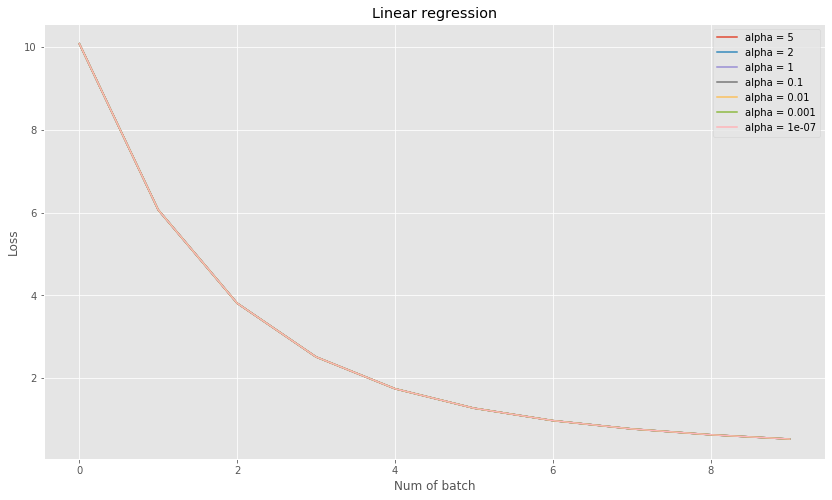

In [12]:
fig = plt.figure(figsize=(14,8))

alphas = [5, 2, 1, 0.1, 0.01, 0.001, 0.0000001]
for alpha in alphas:
    clsf_lin = MySGDClassifier(batch_generator, C=2, alpha=0.01, 
                               batch_size=10000, max_epoch=10, model_type='lin_reg')
    clsf_lin.fit(X, y)
    mean_loss = []
    for i in range(len(clsf_lin.errors_log['loss'])//10):
        mean_loss.append(np.array(clsf_lin.errors_log['loss'][10*i:10*(i+1)]).mean())
    plt.plot(np.arange(len(mean_loss)), mean_loss, label='alpha = ' + str(alpha))

plt.xlabel('Num of batch')
plt.ylabel('Loss')
plt.title('Linear regression')
plt.legend()

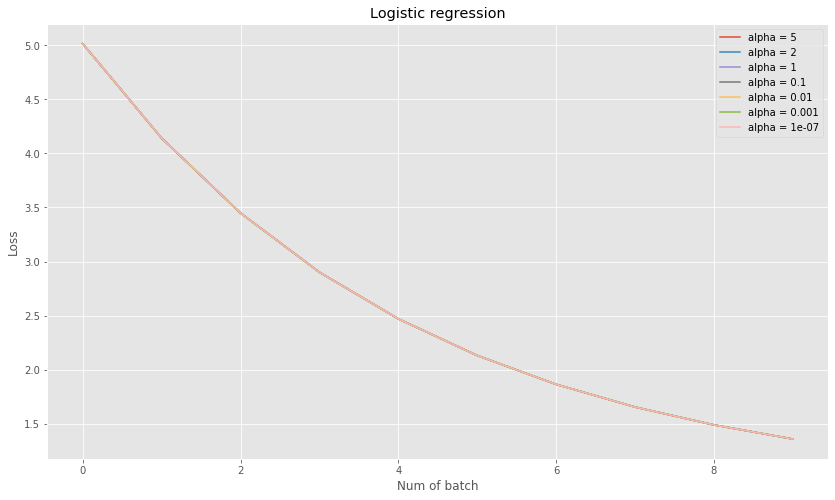

In [13]:
fig = plt.figure(figsize=(14,8))

alphas = [5, 2, 1, 0.1, 0.01, 0.001, 0.0000001]
for alpha in alphas:
    clsf_log = MySGDClassifier(batch_generator, C=2, alpha=0.01, 
                               batch_size=10000, max_epoch=10, model_type='log_reg')
    clsf_log.fit(X, y)
    mean_loss = []
    for i in range(len(clsf_log.errors_log['loss'])//10):
        mean_loss.append(np.array(clsf_log.errors_log['loss'][10*i:10*(i+1)]).mean())
    plt.plot(np.arange(len(mean_loss)), mean_loss, label='alpha = ' + str(alpha))
    
plt.xlabel('Num of batch')
plt.ylabel('Loss')
plt.title('Logistic regression')
plt.legend()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коэф. регуляризации С из `np.logspace(3, -3, 10)` 

/home/roman/.local/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/usr/lib/python3/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply
/home/roman/.local/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in subtract
/usr/lib/python3/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in true_divide


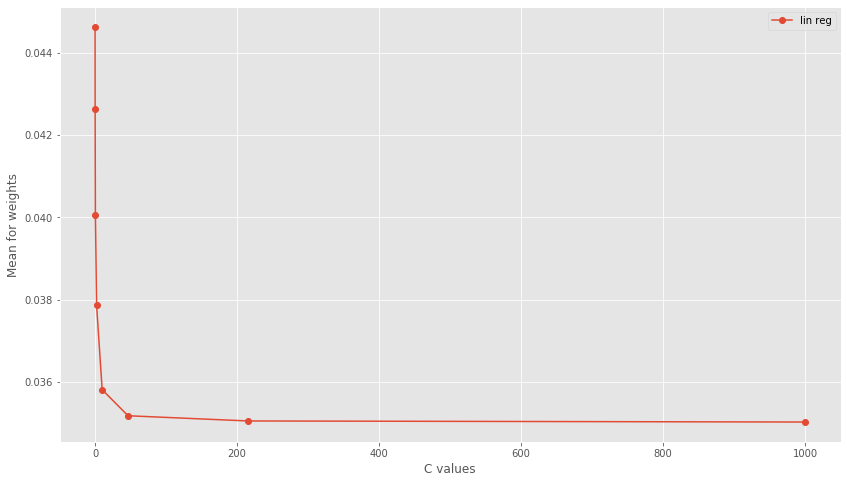

In [14]:
fig = plt.figure(figsize=(14,8))

mean_weights_lin = []
for C in np.logspace(3, -3, 10):
    clsf_lin = MySGDClassifier(batch_generator, C=C, alpha=0.01, 
                               batch_size=1000, max_epoch=10, model_type='lin_reg')
    clsf_lin.fit(X, y)
    mean_weights_lin.append(np.array(clsf_lin.weights).mean())

plt.plot(np.logspace(3, -3, 10), mean_weights_lin, '-o', label='lin reg')
plt.xlabel('C values')
plt.ylabel('Mean for weights')
plt.legend()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log2
/usr/lib/python3/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/lib/python3/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in true_divide


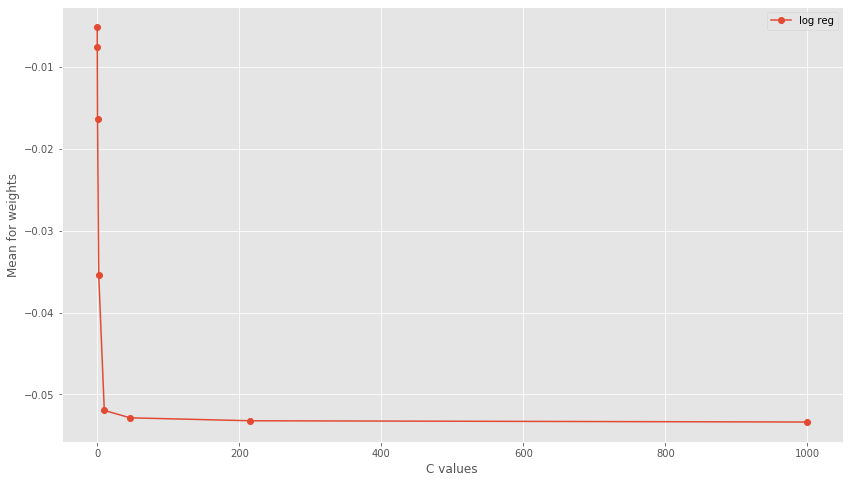

In [15]:
fig = plt.figure(figsize=(14,8))

mean_weights_log = []
for C in np.logspace(3, -3, 10):
    clsf_log = MySGDClassifier(batch_generator, C=C, alpha=0.01, batch_size=1000, max_epoch=10, model_type='log_reg')
    clsf_log.fit(X, y)
    mean_weights_log.append(np.array(clsf_log.weights).mean())

plt.plot(np.logspace(3, -3, 10), mean_weights_log, '-o', label='log reg')
plt.xlabel('C values')
plt.ylabel('Mean for weights')
plt.legend()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [16]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    
    for num_line, line in enumerate(f):
        
        if num_line == 0:
            continue
            
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
            
        doc_to_title[doc_id] = title
        
print (len(doc_to_title))

28026


In [17]:
import pandas as pd

train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}

for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
        
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [18]:
import numpy as np
y_train = []
X_train = []
groups_train = []

for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        
        for j in range(0, len(docs)):
            if k == j:
                continue
                
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
            
        X_train.append(sorted(all_dist, reverse=True)[0:15])
        
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train.shape, y_train.shape, groups_train.shape)

(11690, 15) (11690,) (11690,)


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [19]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [20]:
st_sc = StandardScaler()
X_train = st_sc.fit_transform(X_train)

In [21]:
batch_sizes = [100, 250, 500, 750, 1000, 2000]
best_score = 0
best_batch_size = 100

for batch_size in batch_sizes:
    lin_regr = MySGDClassifier(batch_generator, C=0.1, alpha=0.05,
                               batch_size=batch_size, max_epoch=10, model_type='lin_reg')
    lin_regr.fit(X_train, y_train)
    y_pred = lin_regr.predict(np.c_[np.ones(X_train.shape[0]), X_train])
    y_pred[y_pred <= 0.5] = 0
    y_pred[y_pred > 0.5] = 1
    score = f1_score(y_pred, y_train)
    
    if score > best_score:
        best_score = score
        best_batch_size = batch_size
        
best_score, best_batch_size

(0.6160667709963485, 100)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

In [150]:
differ_groups = set(groups_train)
inds = np.arange(len(X_train))
flag = 0
np.random.seed(0)

for group in differ_groups:
    group_inds = inds[groups_train == group]
    np.random.shuffle(group_inds)
    bound = int(len(group_inds) * 0.8)
    
    if flag == 0:
        x_train_ = X_train[group_inds[0:bound]]
        x_val_ = X_train[group_inds[bound:]]
        y_train_ = y_train[group_inds[0:bound]]
        y_val_ = y_train[group_inds[bound:]]
        flag = 1
        
    x_train_ = np.concatenate((x_train_, X_train[group_inds[0:bound]]), axis=0)
    x_val_ = np.concatenate((x_val_, X_train[group_inds[bound:]]), axis=0)
    y_train_ = np.concatenate((y_train_, y_train[group_inds[0:bound]]), axis=0)
    y_val_ = np.concatenate((y_val_, y_train[group_inds[bound:]]), axis=0)

In [164]:
C_values = np.logspace(4, -4, 100)
alpha_values = [0.01, 0.02, 0.05, 0.001, 0.002, 0.005]
max_epoch_values = [5, 10, 15, 25, 50]
model_type_values = ['lin_reg', 'log_reg']
thresholds = [0.01*i for i in range(-100, 100)]

best_params = {'C': 2, 'alpha': 0.01, 'max_epoch': 10, 'model_type': 'lin_reg', 'threshold': 0.5}
best_score = 0

for model_type in model_type_values:
    for max_epoch in max_epoch_values:
        for alpha in alpha_values:
            for C in C_values:
                clsfr = MySGDClassifier(batch_generator, C=C, alpha=alpha, batch_size=500,
                                        max_epoch=max_epoch, model_type=model_type)
                clsfr.fit(x_train_, y_train_)
                
                
                for threshold in thresholds:
                    
                    y_pred_ = clsfr.predict(np.c_[np.ones(x_val_.shape[0]), x_val_])

                    if np.isnan(y_pred_).any():
                        continue

                    if model_type == 'lin_reg':
                        y_pred_[y_pred_ < threshold] = 0
                        y_pred_[y_pred_ >= threshold] = 1
                    else:
                        y_pred_[y_pred_ < threshold] = 0
                        y_pred_[y_pred_ >= threshold] = 1

                    score = f1_score(y_pred_, y_val_)

                    if score > best_score:
                        best_score = score
                        best_params = {'C': C,'alpha': alpha, 'max_epoch': max_epoch,
                                       'model_type': model_type, 'threshold': threshold}

/home/roman/.local/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: overflow encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in square
/usr/lib/python3/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in multiply
/usr/lib/python3/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in true_divide
/usr/lib/python3/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in add
/home/roman/.local/lib/python3.6/site-packages/numpy/core/_methods.py:38: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value e

In [165]:
best_params, best_score

({'C': 14.849682622544636,
  'alpha': 0.02,
  'max_epoch': 50,
  'model_type': 'log_reg',
  'threshold': 0.28},
 0.6374193548387097)

In [166]:
C, alpha, max_epoch, model_type, threshold = best_params.values()

In [167]:
clsfr = MySGDClassifier(batch_generator, C=C, alpha=alpha, batch_size=500,
                        max_epoch=max_epoch, model_type=model_type)
clsfr.fit(x_train_, y_train_)
y_pred_ = clsfr.predict(np.c_[np.ones(x_val_.shape[0]), x_val_])
y_pred_[y_pred_ < threshold] = 0
y_pred_[y_pred_ >= threshold] = 1
score = f1_score(y_pred_, y_val_)
score

0.6374193548387097

In [168]:
y_pred_tr_ = clsfr.predict(np.c_[np.ones(x_train_.shape[0]), x_train_])
y_pred_tr_[y_pred_tr_ < threshold] = 0
y_pred_tr_[y_pred_tr_ >= threshold] = 1
score = f1_score(y_pred_tr_, y_train_)
score

0.6141359485965505

In [169]:
Counter(y_pred_tr_)

Counter({0.0: 6149, 1.0: 3235})

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [136]:
import sklearn.metrics as metrics

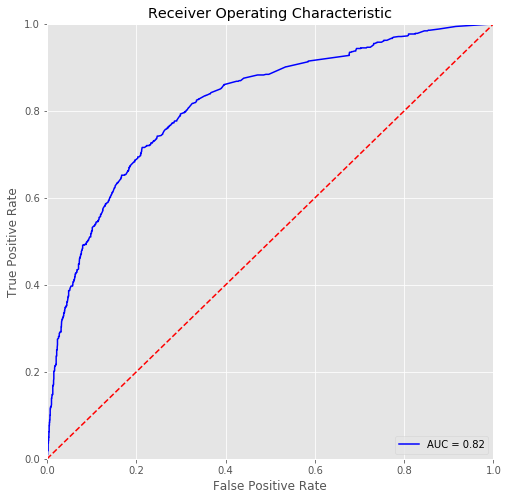

In [170]:
y_pred_ = clsfr.predict(np.c_[np.ones(x_val_.shape[0]), x_val_])
fpr, tpr, thr = metrics.roc_curve(y_val_, y_pred_)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [171]:
thresholds = [0.01*i for i in range(-100, 100)]
best_roc_auc = 0
best_threshold = 0.5

for threshold in thresholds:
    y_pred_ = clsfr.predict(np.c_[np.ones(x_val_.shape[0]), x_val_])
    y_pred_[y_pred_ < threshold] = 0
    y_pred_[y_pred_ >= threshold] = 1
    fpr, tpr, thr = metrics.roc_curve(y_val_, y_pred_)
    roc_auc = metrics.auc(fpr, tpr)
    
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_threshold = threshold
        
best_roc_auc, best_threshold

(0.7514518061109143, 0.28)

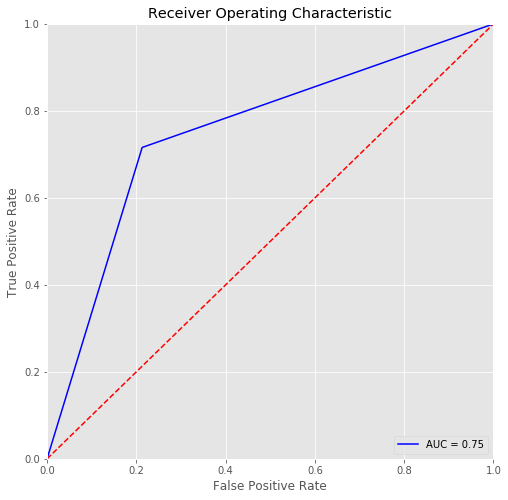

In [172]:
y_pred_ = clsfr.predict(np.c_[np.ones(x_val_.shape[0]), x_val_])
y_pred_[y_pred_ < best_threshold] = 0
y_pred_[y_pred_ >= best_threshold] = 1

fpr, tpr, thr = metrics.roc_curve(y_val_, y_pred_)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

In [140]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}

for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    pair_id = new_doc['pair_id']
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
        
    testgroups_titledata[doc_group].append((pair_id, doc_id, title))

In [141]:
y_test = []
X_test = []
groups_test = []
pair_id_test = []

for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    
    for k, (pair_id, doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        pair_id_test.append(pair_id)
        all_dist = []
        words = set(title.strip().split())
        
        for j in range(0, len(docs)):
            if k == j:
                continue
            pair_id_j, doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
            
        X_test.append(sorted(all_dist, reverse=True)[0:15])
        
X_test = np.array(X_test)
groups_test = np.array(groups_test)
pair_id_test = np.array(pair_id_test)
print (X_test.shape, groups_test.shape, pair_id_test.shape)

(16627, 15) (16627,) (16627,)


In [142]:
X_test = st_sc.transform(X_test)

In [173]:
from collections import Counter
y_pred_test = clsfr.predict(np.c_[np.ones(X_test.shape[0]), X_test])
y_pred_test[y_pred_test < best_threshold] = 0
y_pred_test[y_pred_test >= best_threshold] = 1
Counter(y_pred_test)

Counter({0.0: 10906, 1.0: 5721})

In [174]:
file = open('submissions.csv', 'w')
file.write('pair_id,target\n')
for i in range(len(y_pred_test)):
    file.write(str(pair_id_test[i]) + ',' + str(int(y_pred_test[i])) + '\n')
file.close()

In [177]:
file = open('best_params.txt', 'w')
for pair in best_params.items():
    file.write(str(pair) + '\n')
file.close()

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

In [36]:
# ник: rbichaev

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

-

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** не нужно давать два домашних задания на две недели с ПЕРЕСЕЧЕНИЕМ в неделю ***